In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

//anaconda3/envs/zendesk/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
matplotlib.rcParams.update({'font.size': 15})

In [3]:
%matplotlib notebook

In [102]:
df = pd.read_csv('../data/src_event_history.csv')

In [164]:
query="""select * from personal.src_non_pay_cancellations_event_history limit 5;"""

In [160]:
from sqlalchemy import create_engine
import os

attune_dw_host = os.getenv("ATTUNE_DW_HOST")
attune_dw_user = os.getenv("ATTUNE_DW_USER")
attune_dw_db = os.getenv("ATTUNE_DW_DB", "attune_dw")
port = "5432"


class Connection:
    def __init__(self):
        pass

    def dw_engine(self):
        connection_string = (
            f"postgresql://{attune_dw_user}@{attune_dw_host}:{port}/{attune_dw_db}"
        )
        return create_engine(connection_string)

In [161]:
conn = Connection().dw_engine()

In [165]:
pd.read_sql_query(query, con=conn)

account_number              policy_number event_history  \
0     0000211474  MORSTAN00001HIBP-17728-01             i   
1     0000256453   ORCHIA00001HIBP-28035-01             i   
2     0000316716    AJGALL0001HIBP-39862-01             i   
3     0000521037  MORSTAN00001HIBP-21604-01           iii   
4     0000659842   CMFRST00001HIBP-36232-01             i   

                                            event_ts  
0                              [2019-06-14 00:00:00]  
1                              [2019-10-20 00:00:00]  
2                              [2020-03-11 00:00:00]  
3  [2019-08-01 00:00:00, 2019-10-25 00:00:00, 202...  
4                              [2020-01-21 00:00:00]

## Exploration

### Add event interval functions and plotting

In [5]:
import re

In [6]:
def sequence_match(history, sequence):
    matches = [(m[1], m.start()) for m in re.finditer(sequence, history)]
    return matches if matches else None

In [110]:
patterns = {'invoices':'(^i+$)', 
            'start-end': '(s[nwi]*e(?![wn]+))'}
for k, v in patterns.items():
    df[k] = df.apply(lambda x: sequence_match(x['event_history'],v), axis=1)

Delinquency Start-End, Normal

In [93]:
# total_se = df[df['start-end'].map(lambda x: len(x)>0)].account_number.count()

In [114]:
sevc = df[~df['start-end'].isnull()]['start-end'].explode().map(lambda x: x[0]).value_counts();
(sevc/sevc.sum()).cumsum()

se             0.442939
swne           0.880611
swnie          0.924528
sie            0.953878
swnne          0.970435
swe            0.984035
swnnie         0.987314
swine          0.990485
swie           0.992098
swniie         0.993549
snwne          0.994571
siie           0.995323
siwe           0.995807
swnniie        0.996183
swnine         0.996506
siiie          0.996828
siiiiie        0.997151
siwne          0.997420
snwnie         0.997635
sne            0.997850
siiiiiie       0.998065
siiiie         0.998226
swninie        0.998387
snwe           0.998549
swniiie        0.998710
siiiiiiie      0.998871
swwe           0.998979
swwnne         0.999086
siiiiiiiiie    0.999194
swnwe          0.999301
swwne          0.999409
swnwne         0.999516
siiiiiiiie     0.999624
siwnie         0.999677
swnnne         0.999731
swnnnie        0.999785
snwnne         0.999839
swinie         0.999892
swniiiie       0.999946
swniiiiie      1.000000
Name: start-end, dtype: float64

Anomalies

In [248]:
df['start-end'].dropna().explode().count()

18603

In [165]:
df[(df.invoices.isnull()) & (df['start-end'].isnull())].\
apply(lambda x: sequence_match(x['event_history'],'(sewn)'),axis=1).explode().count()

5757

In [126]:
anom = df[(df.invoices.isnull()) & (df['start-end'].isnull())].copy()

In [128]:
anom['start'] = anom.apply(lambda x: sequence_match(x['event_history'],'(s)'),axis=1)

In [246]:
anom.start.dropna().explode().count()

12253

In [239]:
anom.head(10)

account_number             event_history  \
5           754369                     isewn   
7          1420143                    isewni   
10         1566409                   isewnne   
11         1881510                isewniiiii   
18         3255436                   iswnswn   
19         4087129              isweniiiiiii   
21         4617323         isweniiiiiiiiiswn   
23         4686589             iisweniiiiiii   
26         5311588                     isewn   
41         8640676  iiiiiiiiiisewniiiiiiiiii   

                                             event_ts invoices start-end  \
5   [2020-07-29 00:00:00.000000, 2020-07-30 00:00:...     None      None   
7   [2019-07-27 00:00:00.000000, 2019-07-28 00:00:...     None      None   
10  [2019-12-24 00:00:00.000000, 2019-12-25 00:00:...     None      None   
11  [2019-06-15 00:00:00.000000, 2019-06-16 00:00:...     None      None   
18  [2020-02-01 00:00:00.000000, 2020-02-02 00:00:...     None      None   
19  [2019-12-25 00:00:00.000000, 2019-12-26 00:00:...     None      None   
21  [2019-11-03 00:00:00.000000, 2019-11-04 00:00:...     None      None   
23  [2019-03-13 00:00:00.000000, 2019-04-13 00:00:...     None      None   
26  [2019-11-11 00:00:00.000000, 2019-11-12 00:00:...     None      None   
41  [2018-11-19 00:00:00.000000, 2018-12-14 00:00:...     None      None   

                start  
5            [(s, 1)]  
7            [(s, 1)]  
10           [(s, 1)]  
11           [(s, 1)]  
18   [(s, 1), (s, 4)]  
19           [(s, 1)]  
21  [(s, 1), (s, 14)]  
23           [(s, 2)]  
26           [(s, 1)]  
41          [(s, 10)]

In [184]:
anom.loc[10].event_ts

['2019-12-24 00:00:00.000000',
 '2019-12-25 00:00:00.000000',
 '2019-12-26 21:14:33.000000',
 '2019-12-28 00:00:00.000000',
 '2019-12-30 00:00:00.000000',
 '2020-01-02 00:00:00.000000',
 '2020-01-08 20:43:11.000000']

In [163]:
anom['start'].explode().count()

12253

In [13]:
def get_start_ts(events_ts, sequence_matches):
    return [events_ts[i[1]] for i in sequence_matches]

In [169]:
anom_dates = anom.apply(lambda x: get_start_ts(x['event_ts'],x['start']), axis=1).\
explode().value_counts().sort_index()

In [154]:
anom_dates.index = pd.to_datetime(anom_dates.index)

In [176]:
norm_dates = df.dropna(subset=['start-end']).apply(lambda x: get_start_ts(x['event_ts'],x['start-end']), axis=1)\
.explode().value_counts().sort_index()

In [177]:
norm_dates.index = pd.to_datetime(norm_dates.index)

<IPython.core.display.Javascript object>


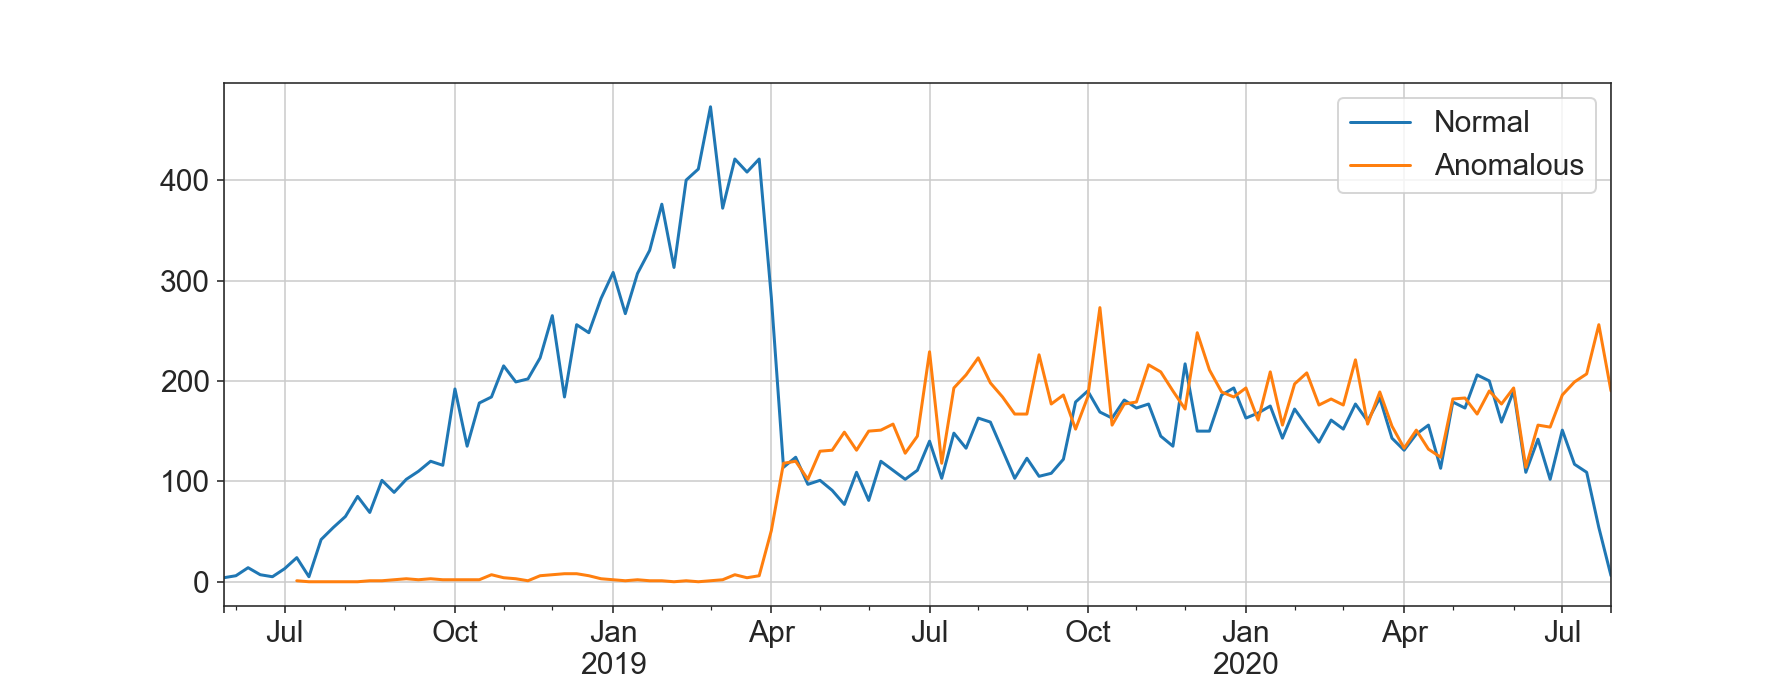

In [1132]:
_, ax = plt.subplots()
norm_dates.resample('W').sum().plot(ax=ax,label='Normal')
anom_dates.resample('W').sum().plot(ax=ax,label='Anomalous')
ax.grid()
ax.legend()

In [182]:
norm_dates.resample('W').sum()[40:60]

2019-03-03    473
2019-03-10    372
2019-03-17    421
2019-03-24    408
2019-03-31    421
2019-04-07    283
2019-04-14    114
2019-04-21    124
2019-04-28     97
2019-05-05    101
2019-05-12     91
2019-05-19     77
2019-05-26    109
2019-06-02     81
2019-06-09    120
2019-06-16    111
2019-06-23    102
2019-06-30    111
2019-07-07    140
2019-07-14    103
Freq: W-SUN, dtype: int64

Metrics

In [192]:
df['se_any'] = df.apply(lambda x: sequence_match(x['event_history'],'(s[nwi]*e)'), axis=1)

In [244]:
df.se_any.dropna().explode().count()

35814

In [197]:
def get_start_end_ts(events_ts, sequence_matches):
    if events_ts and sequence_matches:
        return [(events_ts[i[1]], events_ts[i[1]+len(i[0])-1]) for i in sequence_matches]

In [199]:
df['se_any_bounds'] = df.apply(lambda x: get_start_end_ts(x['event_ts'],x['se_any']), axis=1)

In [209]:
se_diff = df.se_any_bounds.dropna().explode().map(lambda x: pd.to_datetime(x[1]) - pd.to_datetime(x[0]))

Filter

In [380]:
df.loc[10886]

account_number                                           2433487436
event_history                                                  isie
event_ts          [2019-03-06 00:00:00.000000, 2019-03-07 23:15:...
invoices                                                       None
start-end                                                [(sie, 1)]
se_any                                                   [(sie, 1)]
se_any_bounds     [(2019-03-07 23:15:30.000000, 2019-07-29 15:31...
i_bounds                                                       None
s                                                          [(s, 1)]
s_bounds          [(2019-03-07 23:15:30.000000, 2019-03-07 23:15...
Name: 10886, dtype: object

In [379]:
se_diff.sort_values(ascending=False)[90:]

27019   145 days 16:10:34
17429   144 days 16:15:30
35794   144 days 16:14:51
34522   144 days 16:11:57
10886   143 days 16:16:00
               ...       
7406      0 days 00:00:40
17757     0 days 00:00:38
4640      0 days 00:00:20
7406      0 days 00:00:12
17064     0 days 00:00:01
Name: se_any_bounds, Length: 35724, dtype: timedelta64[ns]

In [1130]:
sns.set_style('ticks')

<IPython.core.display.Javascript object>


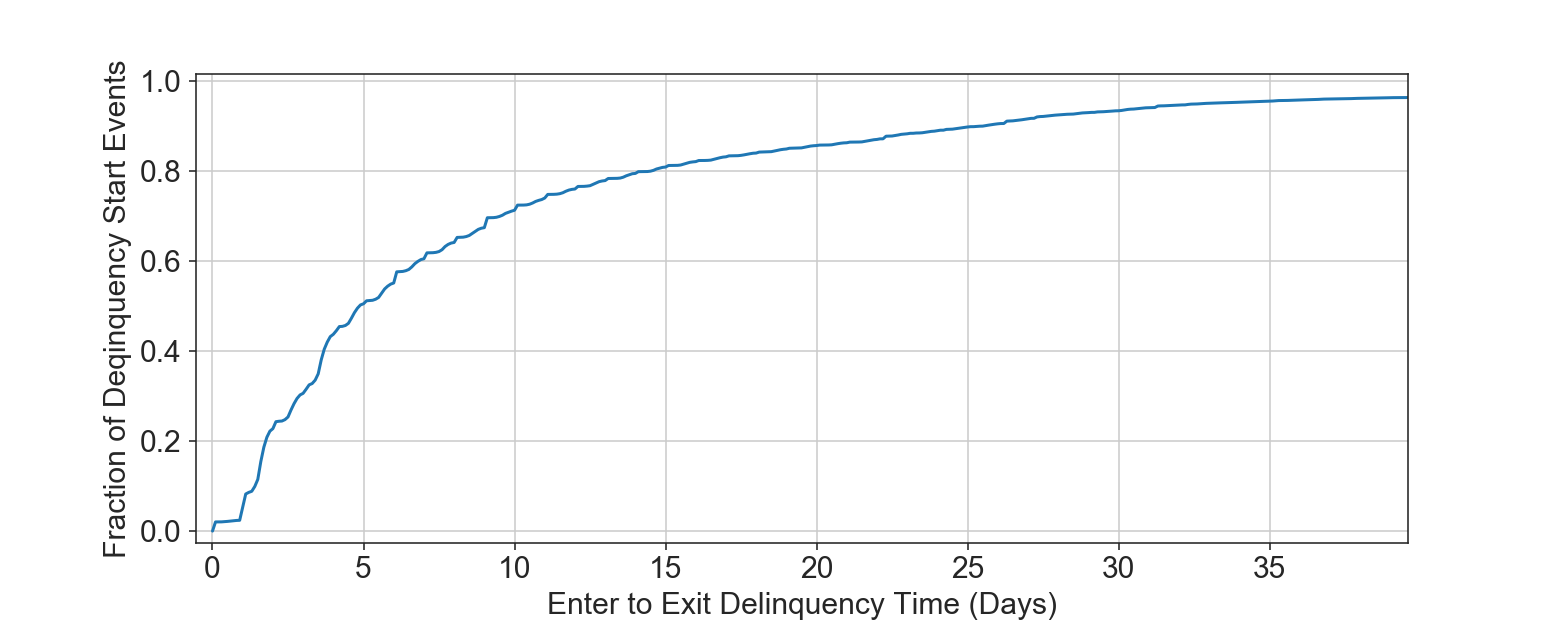

Text(0, 0.5, 'Fraction of Deqinquency Start Events')

In [365]:
_, ax = plt.subplots()
(se_diff.map(lambda x: x.total_seconds()/3600/24).\
 round(1).value_counts().sort_index().cumsum()/35814).plot(grid=True)

ax.set_xlabel('Enter to Exit Delinquency Time (Days)')
ax.set_ylabel('Fraction of Deqinquency Start Events')

- check how long after E are anomalous N,W

In [250]:
anom.loc[5].event_ts

['2020-07-29 00:00:00.000000',
 '2020-07-30 00:00:00.000000',
 '2020-07-31 16:24:01.000000',
 '2020-08-02 00:00:00.000000',
 '2020-08-04 00:00:00.000000']

30-day cohort metrics

In [265]:
see = df[['account_number','se_any_bounds']].\
dropna(subset=['se_any_bounds']).explode('se_any_bounds').reset_index(drop=True).copy()

In [280]:
see = see.join(pd.DataFrame.from_records(see.se_any_bounds, columns=['start','exit'])).drop('se_any_bounds',axis=1)

In [288]:
see = see.astype({'start':np.datetime64, 'exit':np.datetime64})

In [297]:
def timedelta_total_days(start_date, end_date, round_arg=1):
    return round((end_date - start_date).total_seconds()/3600/24, round_arg)

In [298]:
see['diff'] = see.apply(lambda x: timedelta_total_days(x['start'], x['exit']), axis=1)

In [336]:
see[see['diff']<=30].groupby(see.start.dt.strftime('%Y-%m-%w'))['account_number'].nunique()[-10:]

start
2020-06-5    136
2020-06-6    115
2020-07-0    190
2020-07-1    169
2020-07-2    197
2020-07-3    228
2020-07-4    283
2020-07-5    161
2020-07-6    140
2020-08-6      2
Name: account_number, dtype: int64

In [323]:
see.groupby(see.start.dt.strftime('%Y-%m-%w'))['account_number'].nunique()[-10:]

start
2020-06-5    166
2020-06-6    132
2020-07-0    190
2020-07-1    169
2020-07-2    197
2020-07-3    230
2020-07-4    285
2020-07-5    161
2020-07-6    140
2020-08-6      2
Name: account_number, dtype: int64

df

In [325]:
df['s'] = df.apply(lambda x: sequence_match(x['event_history'],'(s)'),axis=1)

In [327]:
df['s_bounds'] = df.apply(lambda x: get_start_end_ts(x['event_ts'],x['s']), axis=1)

In [328]:
sb = df[['account_number','s_bounds']].\
dropna(subset=['s_bounds']).explode('s_bounds').reset_index(drop=True).copy()

In [330]:
sb = sb.join(pd.DataFrame.from_records(sb.s_bounds, columns=['start','exit'])).drop('s_bounds',axis=1)

In [334]:
sb = sb.astype({'start':np.datetime64, 'exit':np.datetime64})

In [355]:
cohort = sb.groupby(sb.start.dt.strftime('%Y-%m-%W'))['account_number'].nunique().reset_index().merge(
    see[see['diff'] <= 30].groupby(see.start.dt.strftime('%Y-%m-%W'))['account_number'].nunique().reset_index(), on='start').copy()

In [356]:
cohort['ratio'] = round(100*cohort.account_number_y/cohort.account_number_x, 1)

In [359]:
# import datetime
# today = datetime.date.today()
# last_monday = today - datetime.timedelta(days=today.weekday())
cohort[-40:]

start  account_number_x  account_number_y  ratio
98   2019-12-50               465               426   91.6
99   2019-12-51               475               443   93.3
100  2019-12-52               112                98   87.5
101  2020-01-00               338               313   92.6
102  2020-01-01               430               398   92.6
103  2020-01-02               490               448   91.4
104  2020-01-03               395               363   91.9
105  2020-01-04               284               261   91.9
106  2020-02-04               162               144   88.9
107  2020-02-05               457               407   89.1
108  2020-02-06               381               346   90.8
109  2020-02-07               442               399   90.3
110  2020-02-08               295               234   79.3
111  2020-03-08               156               133   85.3
112  2020-03-09               493               429   87.0
113  2020-03-10               395               335   84.8
114  2020-03-11               486               399   82.1
115  2020-03-12               415               295   71.1
116  2020-03-13                96                67   69.8
117  2020-04-13               253               157   62.1
118  2020-04-14               385               261   67.8
119  2020-04-15               369               215   58.3
120  2020-04-16               300               188   62.7
121  2020-04-17               201               110   54.7
122  2020-05-17               253               154   60.9
123  2020-05-18               435               268   61.6
124  2020-05-19               465               316   68.0
125  2020-05-20               489               342   69.9
126  2020-05-21               420               307   73.1
127  2020-06-22               465               319   68.6
128  2020-06-23               271               192   70.8
129  2020-06-24               366               267   73.0
130  2020-06-25               322               279   86.6
131  2020-06-26                94                73   77.7
132  2020-07-26               320               276   86.2
133  2020-07-27               380               338   88.9
134  2020-07-28               424               342   80.7
135  2020-07-29               415               299   72.0
136  2020-07-30               266               113   42.5
137  2020-08-30                28                 2    7.1

In [317]:
df['i_bounds'] = df.apply(lambda x: get_start_end_ts(x['event_ts'],x['invoices']), axis=1)

In [320]:
ib = df[['account_number','i_bounds']].\
dropna(subset=['i_bounds']).explode('i_bounds').reset_index(drop=True).copy()

In [321]:
ib = ib.join(pd.DataFrame.from_records(ib.i_bounds, columns=['start','exit'])).drop('i_bounds',axis=1)

In [322]:
ib

account_number                       start                        exit
0              211474  2019-06-14 00:00:00.000000  2020-06-09 00:00:00.000000
1              256453  2019-10-20 00:00:00.000000  2019-10-20 00:00:00.000000
2              316716  2020-03-11 00:00:00.000000  2020-03-11 00:00:00.000000
3              521037  2019-08-01 00:00:00.000000  2020-07-25 00:00:00.000000
4              659842  2020-01-21 00:00:00.000000  2020-01-21 00:00:00.000000
...               ...                         ...                         ...
23696      9996161508  2020-07-13 00:00:00.000000  2020-07-13 00:00:00.000000
23697      9997451789  2019-05-17 00:00:00.000000  2019-06-12 00:00:00.000000
23698      9997541211  2019-07-07 00:00:00.000000  2020-07-02 00:00:00.000000
23699      9998410516  2019-09-15 00:00:00.000000  2020-06-10 00:00:00.000000
23700      9999156620  2019-05-06 00:00:00.000000  2020-05-01 00:00:00.000000

[23701 rows x 3 columns]

2020-08-11 15:04:48  
## Extract Event Sequences

In [103]:
df['event_ts'] = df.event_ts.map(lambda x: [pd.to_datetime(i) for i in x.strip('{}').split(',')])

In [110]:
import datetime
def get_weekly_naccounts_sequence(df, event_dates_col):
    '''For a supplied event sequence dates column, agg number of unique
    account number pairs per week that had the sequence occur'''
    tmp = df.explode(event_dates_col).dropna(subset=[event_dates_col])
    tmp['week'] = tmp[event_dates_col].map(lambda x: (x - datetime.timedelta(days=x.weekday())).strftime('%Y-%m-%d'))
    return tmp.groupby('week')['account_number'].nunique()
#     return tmp.groupby('week').apply(lambda x: len(set(zip(x['account_number'], x['policy_number']))))

def pattern_matches_indices(string, pattern):
    '''returns all matches and starting positions of pattern
    in string'''
    matches = [(m[1], m.start()) for m in re.finditer(pattern, string)]
    return matches if matches else None

def find_sequences_df(pattern, df, event_history_col='event_history', topn=20):
    '''Given df with column of event history strings, apply
    pattern matching to each row and return counts of all matches'''
    sequence_value_counts = df.apply(lambda x: pattern_matches_indices(
        x[event_history_col], pattern), axis=1).dropna().explode().map(lambda x: x[0]).value_counts()
    total = sequence_value_counts.sum()
    print(f"Total number of matches: {total}")
    print(f"Number of unique sequences: {sequence_value_counts.size}")
    topn = min(topn, sequence_value_counts.size)
    print(
        f"Top {topn} sequences compromise {(sequence_value_counts / total)[:topn].sum()} of all events")
    stats = pd.DataFrame(sequence_value_counts, columns=['num_matches'])
    stats['fraction_total'] = stats.transform(lambda x: x/x.sum())
    stats['cumulative_fraction'] = stats['fraction_total'].cumsum()
    return stats

def add_sequence_cols(df, pattern, sequence_col_name, 
                      event_history_col='event_history', event_ts_col='event_ts'):
    '''Add columns to df with event history pattern matches and corresponding dates'''
    df[sequence_col_name] = df.apply(
        lambda x: pattern_matches_indices(x[event_history_col], pattern), axis=1)
    df['_'.join([sequence_col_name, 'dates'])] = df.dropna(subset=[sequence_col_name]).apply(
        lambda x: get_start_ts(x[event_ts_col], x[sequence_col_name]), axis=1)

### Invoice Due

How often accounts have no delinquency activity between invoices

In [1138]:
stats = find_sequences_df('(i+)', df, topn=30)
stats[:10]

Total number of matches: 73599
Number of unique sequences: 20
Top 20 sequences compromise 1.0 of all events


num_matches  fraction_total  cumulative_fraction
i                 45450        0.617536             0.617536
ii                10156        0.137991             0.755527
iii                4044        0.054946             0.810473
iiii               2997        0.040721             0.851194
iiiiiiiiii         2810        0.038180             0.889373
iiiiiiii           1817        0.024688             0.914061
iiiiiiiii          1635        0.022215             0.936276
iiiii              1635        0.022215             0.958491
iiiiiii            1505        0.020449             0.978940
iiiiii             1366        0.018560             0.997500

In [14]:
add_sequence_cols(df, '(i)', 'invoice')

In [79]:
df.head(10)

account_number                policy_number event_history  \
0          211474    MORSTAN00001HIBP-17728-01             i   
1          256453     ORCHIA00001HIBP-28035-01             i   
2          316716      AJGALL0001HIBP-39862-01             i   
3          521037    MORSTAN00001HIBP-21604-01           iii   
4          659842     CMFRST00001HIBP-36232-01             i   
5          754369      PHGRP00001HIBP-46324-01          isme   
6         1132804    MORSTAN00001HIBP-27399-01             i   
7         1420143      RPSSI00001HIBP-21229-01          isme   
8         1458217  DEMETRIOU00001HIBP-34325-01     ismwndeii   
9         1552624    SIACANT00001HIBP-25465-01        iiiiii   

                                            event_ts  \
0                              [2019-06-14 00:00:00]   
1                              [2019-10-20 00:00:00]   
2                              [2020-03-11 00:00:00]   
3  [2019-08-01 00:00:00, 2019-10-25 00:00:00, 202...   
4                              [2020-01-21 00:00:00]   
5  [2020-07-29 00:00:00, 2020-07-30 00:00:00, 202...   
6                              [2019-10-09 00:00:00]   
7  [2019-07-27 00:00:00, 2019-07-28 00:00:00, 201...   
8  [2019-12-24 00:00:00, 2019-12-25 00:00:00, 201...   
9  [2019-09-18 00:00:00, 2019-10-13 00:00:00, 201...   

                                            invoice  \
0                                          [(i, 0)]   
1                                          [(i, 0)]   
2                                          [(i, 0)]   
3                          [(i, 0), (i, 1), (i, 2)]   
4                                          [(i, 0)]   
5                                          [(i, 0)]   
6                                          [(i, 0)]   
7                                          [(i, 0)]   
8                          [(i, 0), (i, 7), (i, 8)]   
9  [(i, 0), (i, 1), (i, 2), (i, 3), (i, 4), (i, 5)]   

                                       invoice_dates invoice_start  \
0                              [2019-06-14 00:00:00]          None   
1                              [2019-10-20 00:00:00]          None   
2                              [2020-03-11 00:00:00]          None   
3  [2019-08-01 00:00:00, 2019-10-25 00:00:00, 202...          None   
4                              [2020-01-21 00:00:00]          None   
5                              [2020-07-29 00:00:00]     [(is, 0)]   
6                              [2019-10-09 00:00:00]          None   
7                              [2019-07-27 00:00:00]     [(is, 0)]   
8  [2019-12-24 00:00:00, 2020-03-19 00:00:00, 202...     [(is, 0)]   
9  [2019-09-18 00:00:00, 2019-10-13 00:00:00, 201...          None   

     invoice_start_dates     start_exit       start_exit_dates  \
0                   None           None                   None   
1                   None           None                   None   
2                   None           None                   None   
3                   None           None                   None   
4                   None           None                   None   
5  [2020-07-29 00:00:00]     [(sme, 1)]  [2020-07-30 00:00:00]   
6                   None           None                   None   
7  [2019-07-27 00:00:00]     [(sme, 1)]  [2019-07-28 00:00:00]   
8  [2019-12-24 00:00:00]  [(smwnde, 1)]  [2019-12-25 00:00:00]   
9                   None           None                   None   

  start_cancel_perm start_cancel_perm_dates invoice_cancel_reinstate  \
0              None                    None                     None   
1              None                    None                     None   
2              None                    None                     None   
3              None                    None                     None   
4              None                    None                     None   
5              None                    None                     None   
6              None                    None                     None   
7

In [867]:
# get_sequence_counts(df, 'invoice_dates').tail(20)

### Invoice-Start Delinquency

Will use 'is', but should decide on whether delinq exit or rescind can happen before.

In [1140]:
stats = find_sequences_df('(i[^i]*?s)', df, topn=10)
stats[:10]

Total number of matches: 33016
Number of unique sequences: 34
Top 10 sequences compromise 0.9987884661982069 of all events


num_matches  fraction_total  cumulative_fraction
is           32717        0.990944             0.990944
ides            79        0.002393             0.993337
ies             69        0.002090             0.995426
ics             44        0.001333             0.996759
ieds            30        0.000909             0.997668
iws             13        0.000394             0.998062
iwes             9        0.000273             0.998334
iders            6        0.000182             0.998516
idecs            5        0.000151             0.998667
iceds            4        0.000121             0.998788

In [15]:
add_sequence_cols(df, '(is)', 'invoice_start')

### Start delinquency

15 possible errors

In [1142]:
stats = find_sequences_df('(s+)', df, topn=30)
stats[:10]

Total number of matches: 33947
Number of unique sequences: 2
Top 2 sequences compromise 1.0 of all events


num_matches  fraction_total  cumulative_fraction
s         33932        0.999558             0.999558
ss           15        0.000442             1.000000

In [23]:
add_sequence_cols(df, '(s)', 'start')

### Start-end delinquency

Consider sequences that exit delinquency because of cancellation separately

In [1176]:
# stats = find_sequences_df('s[mwnid]{1,5}(.*?)e', df, topn=20) 
# stats = find_sequences_df('(s.*?e)', df, topn=20) #ismwneotldcr
stats = find_sequences_df('(s[mwnid]*?e)', df, topn=20) #ismwneotldcr

Total number of matches: 30836
Number of unique sequences: 116
Top 20 sequences compromise 0.9926384745103126 of all events


In [1177]:
stats[:40]

num_matches  fraction_total  cumulative_fraction
sme               10541        0.341841             0.341841
smwe               8192        0.265664             0.607504
smwnde             4107        0.133188             0.740693
smwne              3739        0.121254             0.861947
se                 2825        0.091614             0.953561
smwnide             372        0.012064             0.965625
smwnie              211        0.006843             0.972467
swme                183        0.005935             0.978402
smie                 92        0.002984             0.981385
smwie                63        0.002043             0.983428
swmne                58        0.001881             0.985309
swmnde               56        0.001816             0.987125
smiwe                44        0.001427             0.988552
sde                  30        0.000973             0.989525
smwndwme             22        0.000713             0.990239
smwinde              19        0.000616             0.990855
sie                  19        0.000616             0.991471
sime                 14        0.000454             0.991925
sdme                 11        0.000357             0.992282
simwe                11        0.000357             0.992638
smwniide             10        0.000324             0.992963
smde                  9        0.000292             0.993255
sne                   8        0.000259             0.993514
simwnde               8        0.000259             0.993774
smwine                7        0.000227             0.994001
smwndmwe              7        0.000227             0.994228
smwwme                7        0.000227             0.994455
smwde                 6        0.000195             0.994649
smwniidwme            6        0.000195             0.994844
swmde                 5        0.000162             0.995006
smwniie               5        0.000162             0.995168
smiwne                5        0.000162             0.995330
sdwe                  5        0.000162             0.995492
swmnide               4        0.000130             0.995622
sdmwe                 4        0.000130             0.995752
smwwe                 4        0.000130             0.995881
swmnie                4        0.000130             0.996011
smme                  4        0.000130             0.996141
swe                   4        0.000130             0.996271
smiwnde               4        0.000130             0.996400

In [16]:
add_sequence_cols(df,'(s[mwnid]*?e)', 'start_exit')

### Start-cancellation (permanent)

Cancellations, exit and rescind delinquency seem to happen in any order on the same day.

In [1147]:
stats = find_sequences_df('(s[^sed]*?[de]{0,2}c)', df) 
# stats = find_sequences_df('(s[mwnid]*?e)', df, topn=20) #ismwneotldcr

Total number of matches: 2074
Number of unique sequences: 42
Top 20 sequences compromise 0.9893924783027966 of all events


In [1148]:
stats[-50:]

num_matches  fraction_total  cumulative_fraction
smwnc                   1142        0.550627             0.550627
smwnic                   525        0.253134             0.803761
smwnidec                 105        0.050627             0.854388
smwnedc                   73        0.035198             0.889585
smwniedc                  70        0.033751             0.923337
smwndec                   69        0.033269             0.956606
swmnic                    14        0.006750             0.963356
sc                         9        0.004339             0.967695
smwniic                    8        0.003857             0.971553
simwnc                     7        0.003375             0.974928
sec                        5        0.002411             0.977338
smwinc                     4        0.001929             0.979267
smwec                      4        0.001929             0.981196
swmnc                      3        0.001446             0.982642
smwniiiic                  3        0.001446             0.984089
swmnedc                    3        0.001446             0.985535
smwniiic                   3        0.001446             0.986982
simwndec                   2        0.000964             0.987946
siwmnc                     2        0.000964             0.988910
smec                       1        0.000482             0.989392
swmndec                    1        0.000482             0.989875
sminwic                    1        0.000482             0.990357
smwniiiiiiic               1        0.000482             0.990839
smwniidec                  1        0.000482             0.991321
simwnic                    1        0.000482             0.991803
swmnidec                   1        0.000482             0.992285
swmniedc                   1        0.000482             0.992768
smwniiiiiiiiic             1        0.000482             0.993250
sedc                       1        0.000482             0.993732
smwniiiedc                 1        0.000482             0.994214
simwnidec                  1        0.000482             0.994696
smwniiiiiic                1        0.000482             0.995178
smiwnc                     1        0.000482             0.995661
snc                        1        0.000482             0.996143
smiwnedc                   1        0.000482             0.996625
simwniiiic                 1        0.000482             0.997107
smwniiiiiidec              1        0.000482             0.997589
smwniiiiiiiiedc            1        0.000482             0.998071
smwniiedc                  1        0.000482             0.998554
smwinedc                   1        0.000482             0.999036
smwniiiiiiiedc             1        0.000482             0.999518
simwnedc                   1        0.000482             1.000000

In [17]:
add_sequence_cols(df,'(s[^sed]*?[de]{0,2}c)', 'start_cancel_perm')

### invoice-reinstated

In [1150]:
# stats = find_sequences_df('(is[^sed]*?[de]{0,2}r)', df, topn=20) #'(s[^sed]*?[de]{0,2}c)'
stats = find_sequences_df('(is[^sed]+?[de]{0,2}r)', df, topn=20) #'(s[^sed]*?[de]{0,2}c)'

Total number of matches: 633
Number of unique sequences: 18
Top 18 sequences compromise 1.0 of all events


In [1151]:
stats[:25]

num_matches  fraction_total  cumulative_fraction
ismwnr               325        0.513428             0.513428
ismwnir               96        0.151659             0.665087
ismwnider             64        0.101106             0.766193
ismwnedr              44        0.069510             0.835703
ismwniedr             42        0.066351             0.902054
ismwnder              39        0.061611             0.963665
iswmnr                 4        0.006319             0.969984
ismwinr                4        0.006319             0.976303
ismwniiiiir            3        0.004739             0.981043
iswmnir                3        0.004739             0.985782
ismwniir               2        0.003160             0.988942
iswmnedr               1        0.001580             0.990521
isimwniedr             1        0.001580             0.992101
ismwinder              1        0.001580             0.993681
ismwniiiir             1        0.001580             0.995261
ismwr                  1        0.001580             0.996840
ismwniiir              1        0.001580             0.998420
ismwniider             1        0.001580             1.000000

In [18]:
add_sequence_cols(df,'(is[^sed]+?[de]{0,2}r)', 'invoice_cancel_reinstate')

## Make weekly funnel

In [104]:
add_sequence_cols(df, '(i)', 'invoice')
add_sequence_cols(df, '(is)', 'invoice_start')
add_sequence_cols(df, '(s)', 'start')
add_sequence_cols(df, '(s[mwnid]*?e)', 'start_exit')
add_sequence_cols(df, '(s[^sed]*?[de]{0,2}c)', 'start_cancel_perm')
add_sequence_cols(df, '(is[^sed]+?[de]{0,2}r)', 'invoice_cancel_reinstate')
df.replace({np.nan: None}, inplace=True)

In [111]:
concat_dict = {}
for i, c in enumerate(df.filter(like='dates').columns):
    name = '_'.join([c.replace('-','_').split('_dates')[0],'count'])
    concat_dict.update({name:get_weekly_naccounts_sequence(df, c)})
funnel = pd.concat(concat_dict, axis=1).fillna(0)
funnel.index = pd.to_datetime(funnel.index)

In [166]:
funnel.tail()

invoice_count  invoice_start_count  start_count  start_exit_count  \
2020-07-13           2059                  144          154               136   
2020-07-20           1912                  157          156               137   
2020-07-27           1441                  114          123               108   
2020-08-03           1674                  230          210               162   
2020-08-10           1610                  189          226                84   

            start_cancel_perm_count  invoice_cancel_reinstate_count  \
2020-07-13                     11.0                             0.0   
2020-07-20                     11.0                             0.0   
2020-07-27                      0.0                             0.0   
2020-08-03                      0.0                             0.0   
2020-08-10                      0.0                             0.0   

            pct_invoice_start  pct_delinq_exit  pct_delinq_cancel_perm  \
2020-07-13               6.99            88.31                    7.14   
2020-07-20               8.21            87.82                    7.05   
2020-07-27               7.91            87.80                    0.00   
2020-08-03              13.74            77.14                    0.00   
2020-08-10              11.74            37.17                    0.00   

            pct_invoice_reinstated  pct_delinq_reinstated  
2020-07-13                     0.0                    0.0  
2020-07-20                     0.0                    0.0  
2020-07-27                     0.0                    0.0  
2020-08-03                     0.0                    0.0  
2020-08-10                     0.0                    0.0

In [117]:
tolerance = 4
funnel['pct_invoice_start'] = (funnel['invoice_start_count'] /
                               funnel['invoice_count']).round(tolerance)*100

funnel['pct_delinq_exit'] = (funnel['start_exit_count'] /
                               funnel['start_count']).round(tolerance)*100

funnel['pct_delinq_cancel_perm'] = (funnel['start_cancel_perm_count'] /
                               funnel['start_count']).round(tolerance)*100

funnel['pct_invoice_reinstated'] = (funnel['invoice_cancel_reinstate_count'] /
                               funnel['invoice_count']).round(tolerance)*100
funnel['pct_delinq_reinstated'] = (funnel['invoice_cancel_reinstate_count'] /
                               funnel['start_count']).round(tolerance)*100

In [173]:
funnel.filter(regex='invoice_count|pct.*').reset_index().rename(columns={'index':'week'})

week  invoice_count  pct_invoice_start  pct_delinq_exit  \
0   2018-05-21              7              71.43           100.00   
1   2018-05-28              8              50.00           100.00   
2   2018-06-04             31              54.84           100.00   
3   2018-06-11             20              25.00           100.00   
4   2018-06-18             14              28.57           100.00   
..         ...            ...                ...              ...   
112 2020-07-13           2059               6.99            88.31   
113 2020-07-20           1912               8.21            87.82   
114 2020-07-27           1441               7.91            87.80   
115 2020-08-03           1674              13.74            77.14   
116 2020-08-10           1610              11.74            37.17   

     pct_delinq_cancel_perm  pct_invoice_reinstated  pct_delinq_reinstated  
0                      0.00                     0.0                    0.0  
1                      0.00                     0.0                    0.0  
2                     14.29                     0.0                    0.0  
3                      0.00                     0.0                    0.0  
4                      0.00                     0.0                    0.0  
..                      ...                     ...                    ...  
112                    7.14                     0.0                    0.0  
113                    7.05                     0.0                    0.0  
114                    0.00                     0.0                    0.0  
115                    0.00                     0.0                    0.0  
116                    0.00                     0.0                    0.0  

[117 rows x 7 columns]

### Invoice count check

In [31]:
fdf = pd.read_csv('../data/funnel_ts_inv_counts.csv')

In [41]:
fdf = fdf.astype({'week':np.datetime64})

In [46]:
fdf['week'] = fdf.week.map(lambda x: pd.to_datetime(x))

In [56]:
ts_inv = pd.read_csv('../data/ts_inv_counts.csv', parse_dates=['week'])

<IPython.core.display.Javascript object>


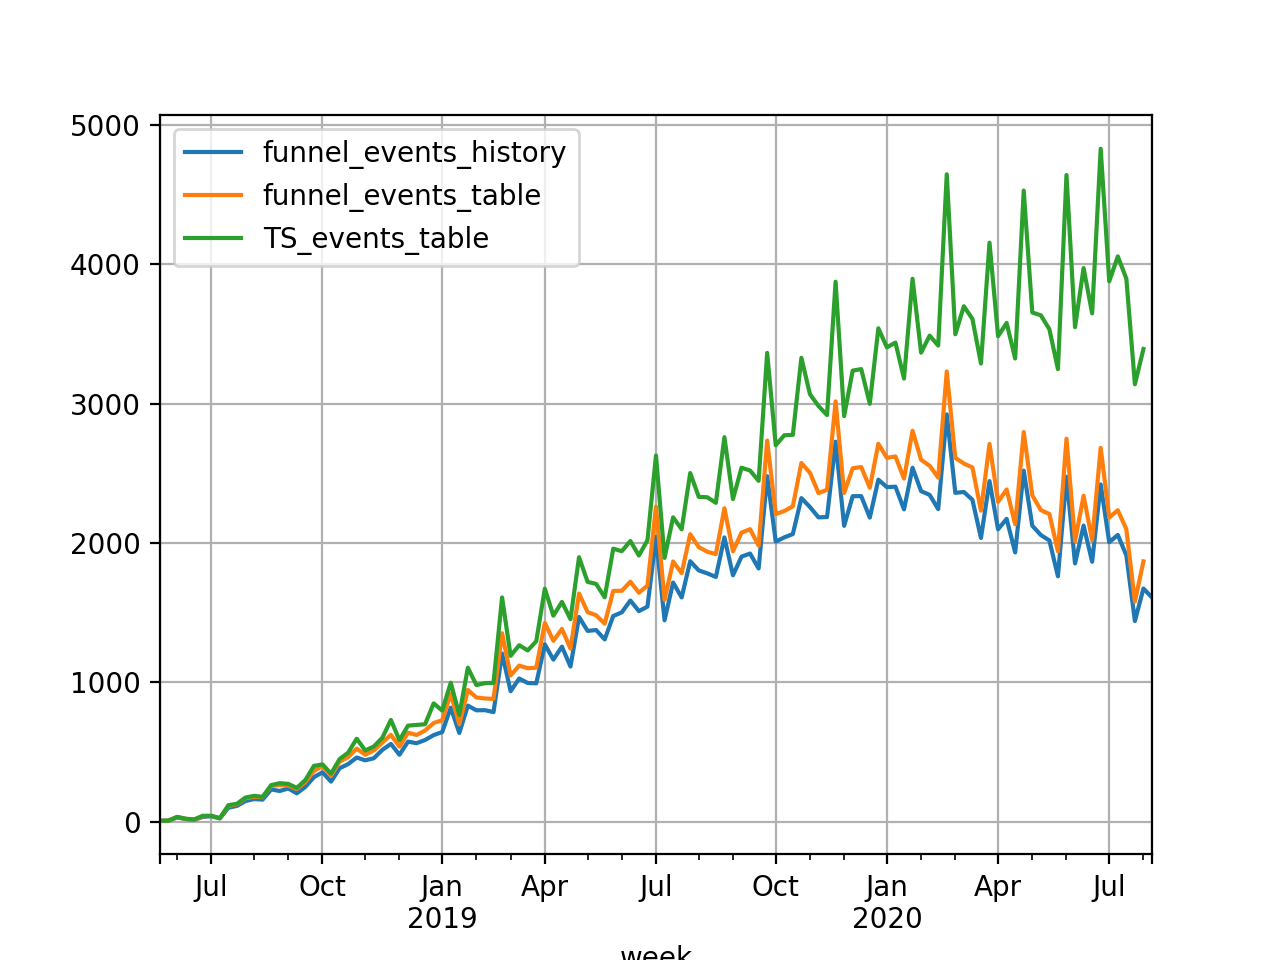

In [119]:
#filter coverwallet
_, ax = plt.subplots()
funnel.invoice_count.plot(grid=True, ax=ax, label='funnel_events_history')
fdf.plot(x='week',y='f_count',ax=ax, label='funnel_events_table')
ts_inv.plot(x='week',y='ts_count',ax=ax, label='TS_events_table')

# pd.Series(funnel.invoice_count.values[:-1]/fdf.f_count.values).plot(ax=ax)
ax.grid()
ax.legend()

In [120]:
funnel.filter(regex='invoice_count|pct.*').to_csv('delinquency_funnel_2020-08-18.csv')

<IPython.core.display.Javascript object>


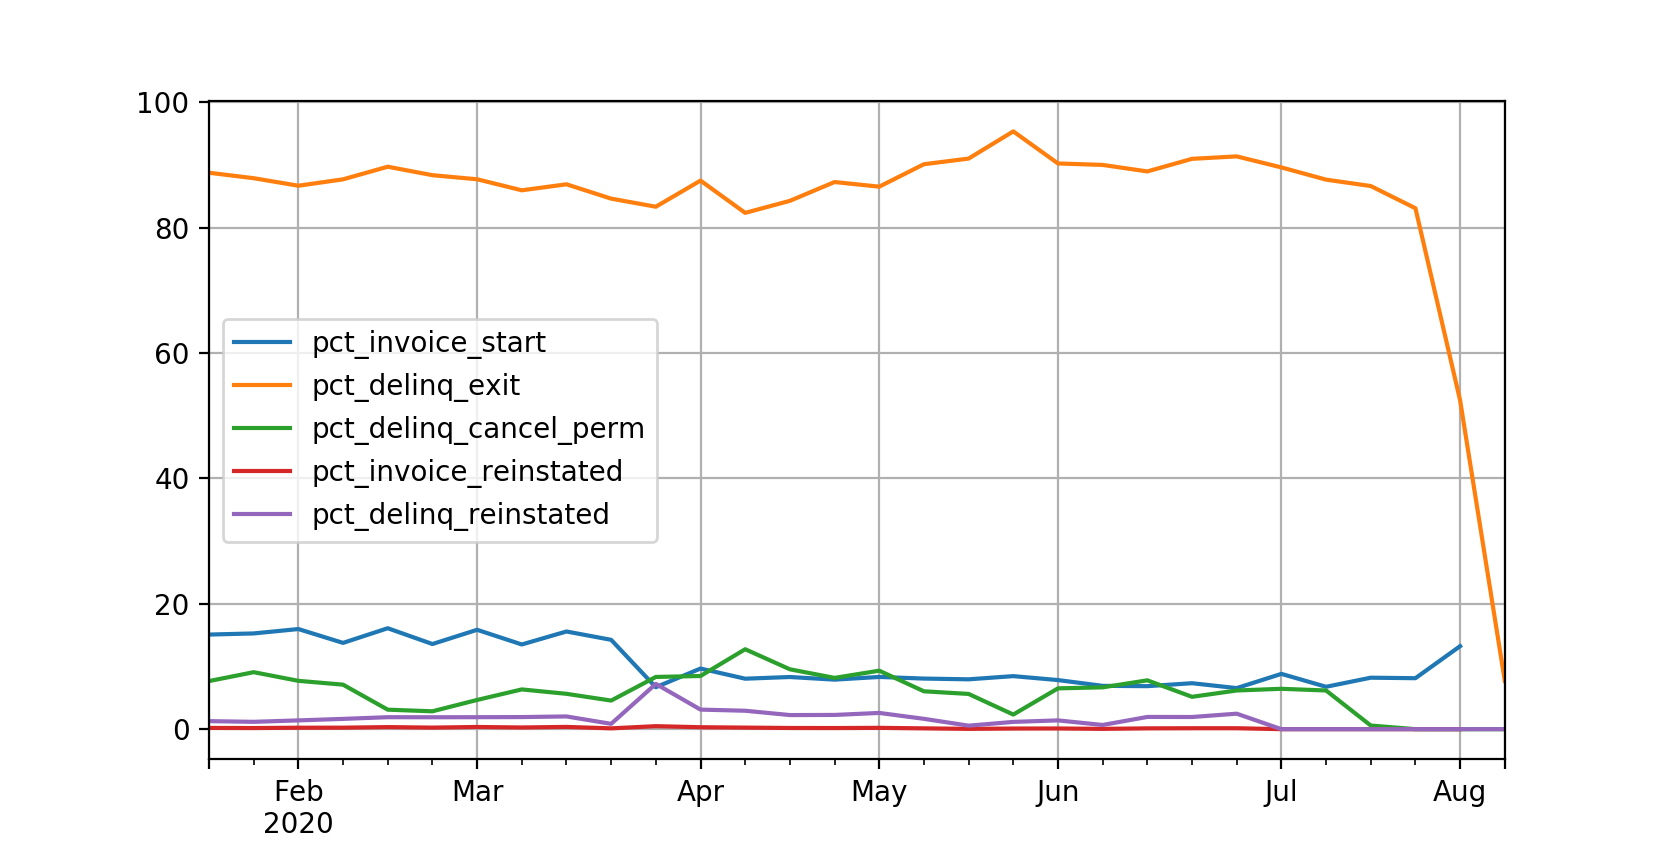

In [99]:
funnel.filter(regex='pct.*')[-30:].plot(grid=True)
# ax.set_xlabel('Enter to Exit Delinquency Time (Days)')
# ax.set_ylabel('Fraction of Deqinquency Start Events')

<IPython.core.display.Javascript object>


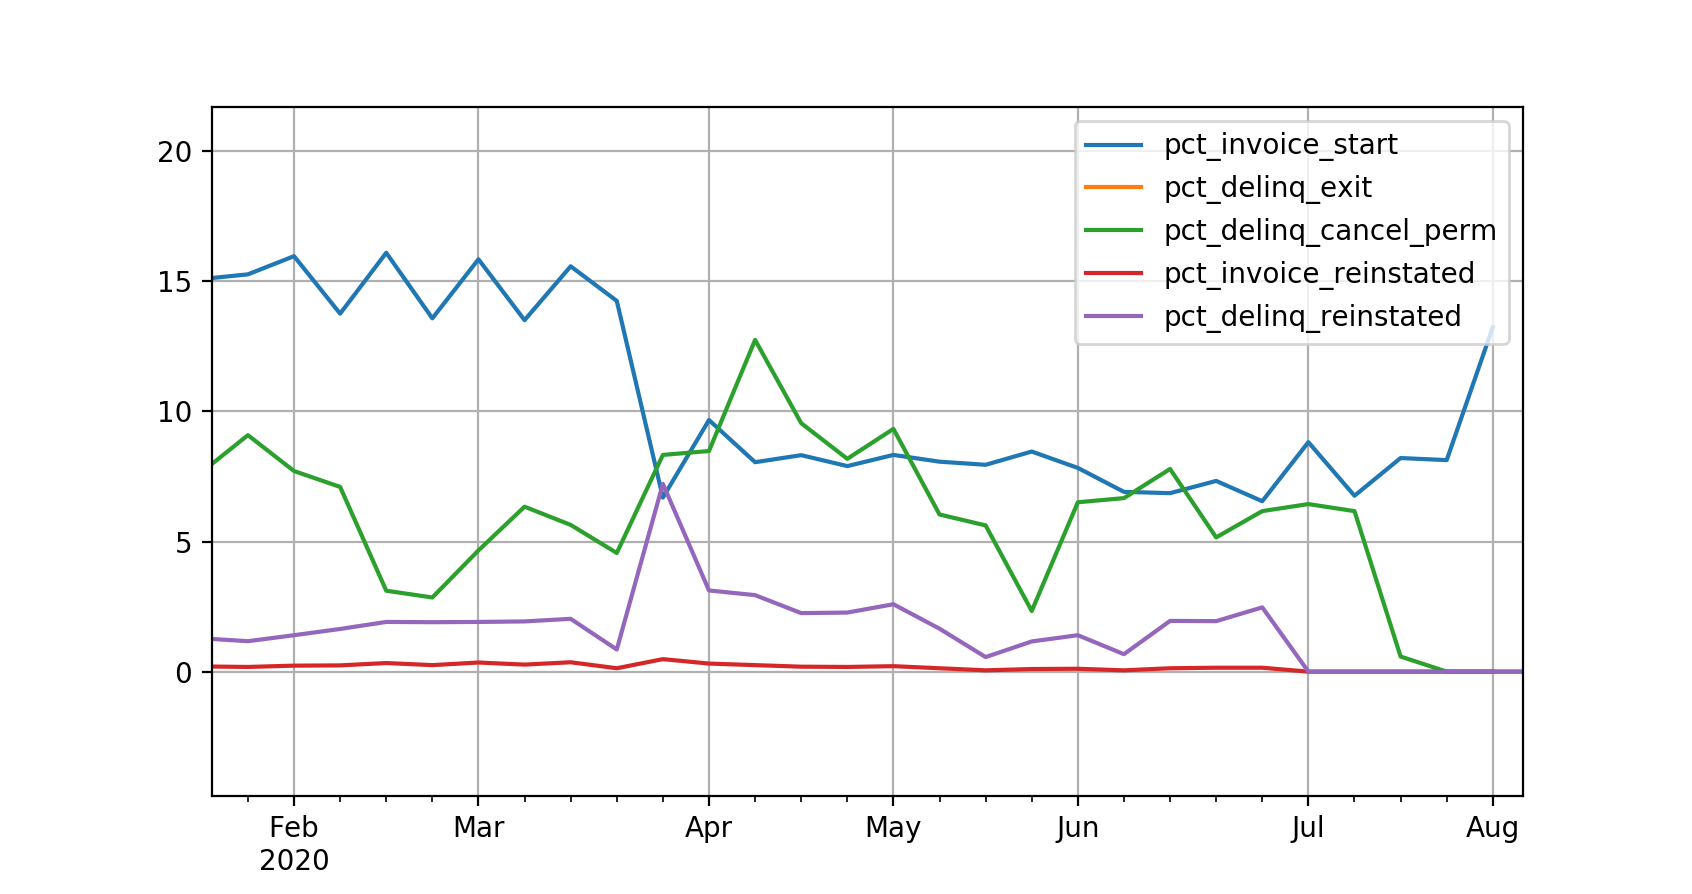

In [100]:
funnel.filter(regex='pct.*')[-30:].plot(grid=True)
# ax.set_xlabel('Enter to Exit Delinquency Time (Days)')
# ax.set_ylabel('Fraction of Deqinquency Start Events')

Rates translation

In [121]:
from ipywidgets import interact

In [159]:
@interact(n_invoices=(1000, 5000, 1000)
          ,start_rate=(0.2, .3, .01)
          ,exit_rate=(0.85, .9, .01)  # fraction of deqlinquencies that exit
          ,cancel_rate=(0.05, .1, .01)  # fraction of deqlinquencies that cancel
          ,exit_delta=(0.01, .1, .01))
def rate_calcs(n_invoices=1000, start_rate=0.2, exit_rate=0.9,
               cancel_rate=0.05, exit_delta=0.05):
    
    other_rate = 1 - exit_rate
    
    new_exit = (1 + exit_delta)*exit_rate
    new_cancel = abs(1 - new_exit)*(cancel_rate/other_rate)
#     new_cancel = cancel_rate - abs(exit_rate - new_exit)/2

    n_start = n_invoices * start_rate
    n_exit = n_start * exit_rate
    n_cancel_delinq = n_start * cancel_rate
    cancel_invoices_rate = n_cancel_delinq / n_invoices

    print(f"Num. Invoices: {n_invoices}")
    print("Delinquency Start Rate")
    print("-"*20)
    print(f"{100*start_rate}%, {n_start} accounts\n")

    print("Delinquency Exit Rate (of accounts that start delinquency)")
    print("-"*20)
    print(f"Initial: {100*exit_rate}%, {n_exit} accounts")
    print(f"New: {100*new_exit}%, {n_start*new_exit} accounts\n")

    print("NPC Rate (of accounts that start delinquency)")
    print("-"*20)
    print(f"Initial: {100*cancel_rate}%, {n_cancel_delinq} accounts")
    print(f"New: {100*new_cancel}%, {n_start*new_cancel} accounts\n")
    
    print("NPC Rate (of accounts with invoices due)")
    print("-"*20)
    print(f"Initial: {100*cancel_invoices_rate}%")
    print(f"New: {100*n_start * new_cancel / n_invoices}%\n")
    
    print("NPC Rate (of all policies)")
    print("-"*20)
    print(f"Initial: {4*100*cancel_invoices_rate}%")
    print(f"New: {4*100*n_start * new_cancel / n_invoices}%")

interactive(children=(IntSlider(value=1000, description='n_invoices', max=5000, min=1000, step=1000), FloatSli…